In [1]:
# ✅ INSTALL REQUIRED LIBRARIES
!pip install xgboost scikit-learn joblib pandas matplotlib shap imbalanced-learn --quiet
!pip install --upgrade xgboost

In [2]:
# ✅ IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import joblib
import random
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [3]:
# ✅ 1. GENERATE SIMULATED INVOICE DATA (SAP-LIKE)
np.random.seed(42)
random.seed(42)

vendor_ids = ['A001', 'A002', 'A003', 'A004', 'A005']
categories = ['IT', 'Office Supplies', 'Maintenance', 'Catering', 'Logistics']
ratings = [1, 2, 3, 4, 5]
regions = ['EMEA', 'AMER', 'APAC']
gl_codes = ['400100', '400200', '400300']
company_codes = ['C001', 'C002', 'C003']
payment_terms = ['30D', '45D', '60D']
block_reasons = ['none', 'price mismatch', 'missing PO', 'approval delay']

data = []
for i in range(1000):
    vendor_id = random.choice(vendor_ids)
    amount = np.random.randint(100, 5000)
    due_in_days = np.random.randint(-10, 31)
    category = random.choice(categories)
    rating = random.choice(ratings)
    company_code = random.choice(company_codes)
    gl_code = random.choice(gl_codes)
    vendor_region = random.choice(regions)
    payment_term = random.choice(payment_terms)
    block_reason = random.choice(block_reasons)
    late_prob = 0.2 if due_in_days >= 0 and rating >= 3 and block_reason == 'none' else 0.7
    payment_status = 'late' if np.random.rand() < late_prob else 'on_time'

    data.append([i+1, vendor_id, amount, due_in_days, category, rating,
                 company_code, gl_code, vendor_region, payment_term, block_reason, payment_status])

cols = ["invoice_id", "vendor_id", "amount", "due_in_days", "category", "rating",
        "company_code", "gl_code", "vendor_region", "payment_term", "block_reason", "payment_status"]

df = pd.DataFrame(data, columns=cols)
df["label"] = df["payment_status"].map({"on_time": 0, "late": 1})

# ✅ 2. FEATURE ENGINEERING
df["is_overdue"] = (df["due_in_days"] < 0).astype(int)
df["urgency_score"] = df["amount"] / (df["due_in_days"].abs() + 1)
df["high_risk_vendor"] = (df["rating"] <= 2).astype(int)
df = pd.get_dummies(df, columns=["category", "company_code", "vendor_region", "payment_term", "block_reason"], drop_first=True)

# ✅ 3. TRAIN/TEST SPLIT
features = ["amount", "due_in_days", "rating", "is_overdue", "urgency_score", "high_risk_vendor"] + \
           [col for col in df.columns if col.startswith(("category_", "company_code_", "vendor_region_", "payment_term_", "block_reason_"))]

X = df[features]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# ✅ 4. CROSS-VALIDATION CONFIG
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ✅ 5. PIPELINES
rf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
])
xgb_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])



🔁 Cross-Validation Results (ROC AUC)



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:53:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:53:49] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:53:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:53:52] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Random Forest AUC scores: [0.52484787 0.55332995 0.69126099 0.65278487 0.62187021], Mean: 0.609
XGBoost AUC scores: [0.56795132 0.59651792 0.67832995 0.61778232 0.56089252], Mean: 0.604


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [09:53:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📈 Random Forest:
               precision    recall  f1-score   support

           0       0.55      0.36      0.44        72
           1       0.70      0.84      0.76       128

    accuracy                           0.67       200
   macro avg       0.63      0.60      0.60       200
weighted avg       0.65      0.67      0.64       200

🎯 RF AUC Score: 0.5782877604166666

📈 XGBoost:
               precision    recall  f1-score   support

           0       0.41      0.36      0.38        72
           1       0.66      0.70      0.68       128

    accuracy                           0.58       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.57      0.58      0.57       200

🎯 XGB AUC Score: 0.5481770833333333


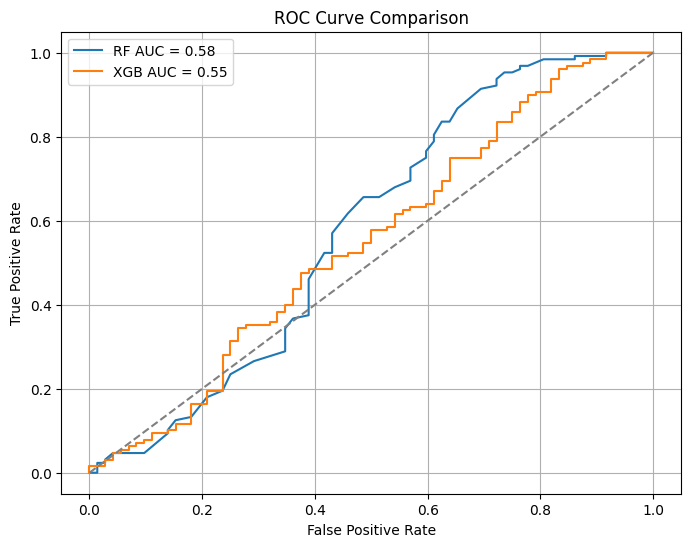

 98%|===================| 394/400 [00:21<00:00]       /usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:746: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


<Figure size 640x480 with 0 Axes>

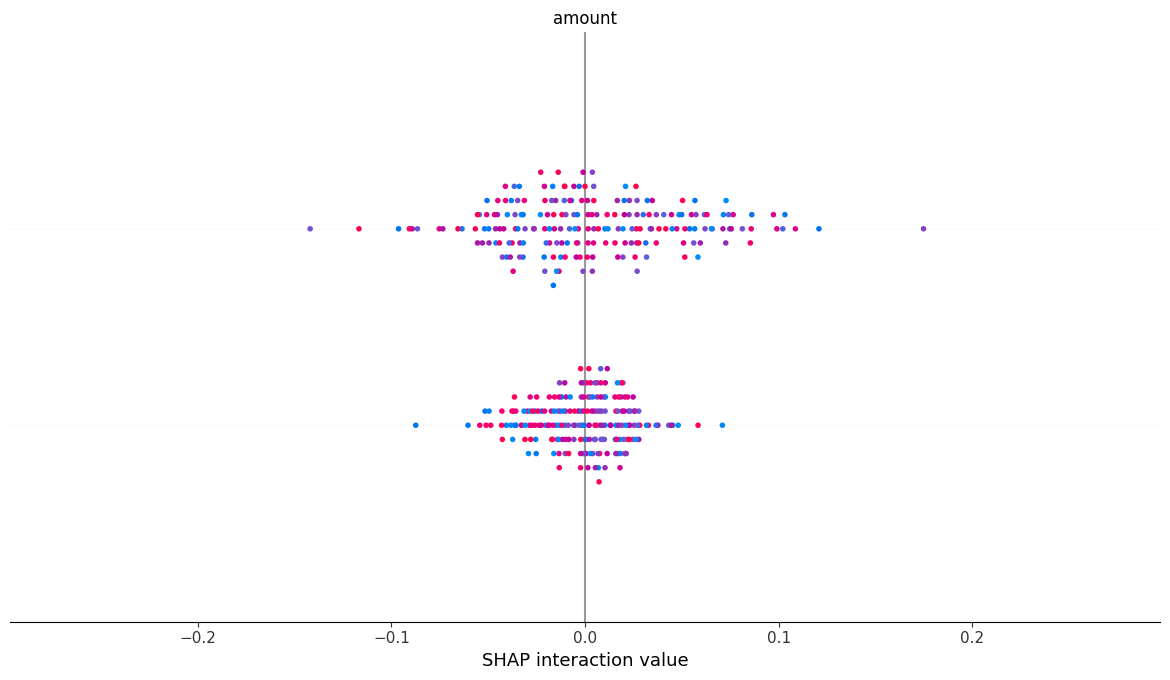

<ipython-input-4-444929487>:48: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(xgb_shap_values, X_explain, show=False)


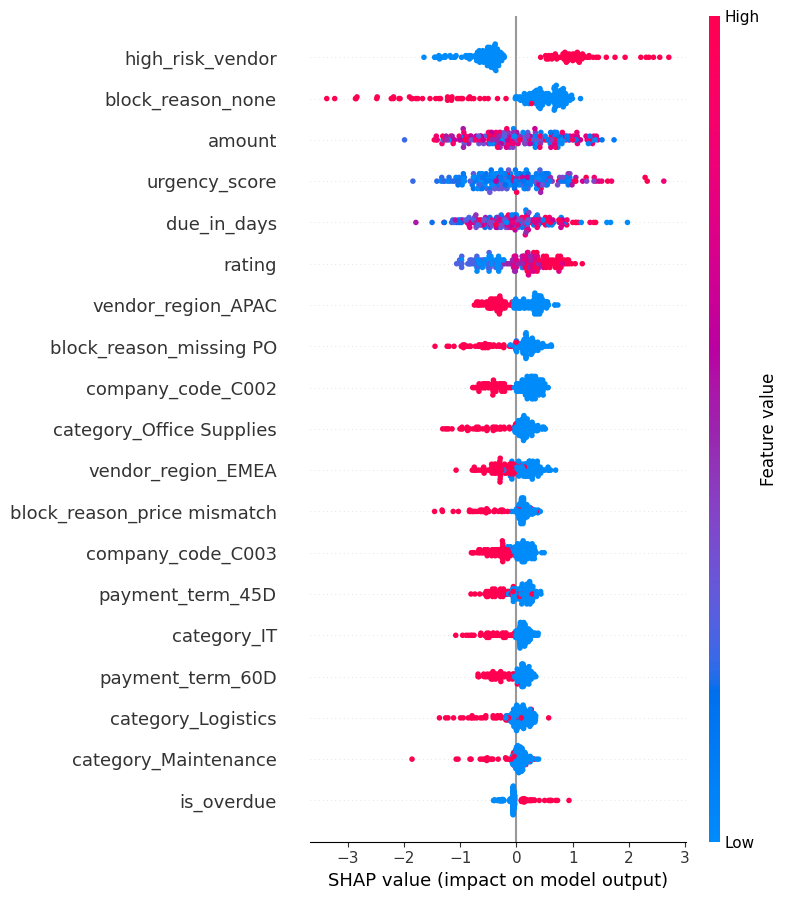

In [4]:
# ✅ 6. CROSS-VALIDATION SCORES
print("\n🔁 Cross-Validation Results (ROC AUC)\n")
rf_auc = cross_val_score(rf_pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
xgb_auc = cross_val_score(xgb_pipeline, X_train, y_train, cv=cv, scoring='roc_auc')
print(f"Random Forest AUC scores: {rf_auc}, Mean: {rf_auc.mean():.3f}")
print(f"XGBoost AUC scores: {xgb_auc}, Mean: {xgb_auc.mean():.3f}")

# ✅ 7. FINAL MODEL TRAINING
rf_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

rf_model = rf_pipeline.named_steps['rf']
xgb_model = xgb_pipeline.named_steps['xgb']
rf_pred = rf_pipeline.predict(X_test)
xgb_pred = xgb_pipeline.predict(X_test)
rf_proba = rf_pipeline.predict_proba(X_test)[:, 1]
xgb_proba = xgb_pipeline.predict_proba(X_test)[:, 1]

# ✅ 8. METRICS
print("\n📈 Random Forest:\n", classification_report(y_test, rf_pred))
print("🎯 RF AUC Score:", roc_auc_score(y_test, rf_proba))
print("\n📈 XGBoost:\n", classification_report(y_test, xgb_pred))
print("🎯 XGB AUC Score:", roc_auc_score(y_test, xgb_proba))

# ✅ 9. ROC CURVE
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"RF AUC = {roc_auc_score(y_test, rf_proba):.2f}")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB AUC = {roc_auc_score(y_test, xgb_proba):.2f}")
plt.plot([0, 1], [0, 1], "--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison"); plt.legend(); plt.grid(True)
plt.savefig("roc_comparison_rf_xgb.png")
plt.show()

# ✅ 10. SHAP EXPLAINABILITY
shap.initjs()
X_explain = X_test.astype("float64")
rf_explainer = shap.Explainer(rf_model, X_explain)
rf_shap_values = rf_explainer(X_explain)
shap.summary_plot(rf_shap_values, X_explain, show=False)
plt.savefig("shap_summary_rf.png")
plt.show()

xgb_explainer = shap.Explainer(xgb_model, X_explain)
xgb_shap_values = xgb_explainer(X_explain)
shap.summary_plot(xgb_shap_values, X_explain, show=False)
plt.savefig("shap_summary_xgb.png")
plt.show()

In [5]:
# ✅ 11. POWER BI KPI EXPORT
vendor_mapping = {"A001": "Vendor IT", "A002": "Office Srl", "A003": "General Maint.",
                  "A004": "Tech Solutions", "A005": "Catering Group"}
df["vendor_name"] = df["vendor_id"].map(vendor_mapping)
kpi_df = df.groupby("vendor_name").agg({
    "due_in_days": "mean",
    "label": "mean",
    "amount": "sum"
}).reset_index()
kpi_df.columns = ["vendor_name", "avg_days_to_due", "late_payment_rate", "total_amount"]
kpi_df.to_csv("invoice_dashboard_data_rf.csv", index=False)

# ✅ 12. ALERT SYSTEM
df_alert = df.copy()
df_alert["risk_score"] = rf_pipeline.predict_proba(df[features])[:, 1]
alert_df = df_alert[df_alert["risk_score"] > 0.75][["invoice_id", "vendor_name", "risk_score"]].copy()
alert_df["priority_action"] = np.where(alert_df["risk_score"] > 0.85, "Immediate follow-up", "Monitor")
alert_df.to_csv("invoice_alerts.csv", index=False)

# ✅ 13. SAVE ARTIFACTS
df.to_csv("invoices_enhanced.csv", index=False)
joblib.dump(rf_model, "random_forest_invoice_model.pkl")
joblib.dump(xgb_model, "xgboost_invoice_model.pkl")












['xgboost_invoice_model.pkl']